In [0]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.options.mode.chained_assignment = None

In [0]:
|!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'1yM9HMSFOTsqKeN7U9THRb_lTxiRPN7Qd' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [0]:
bitcoin_data_downloaded = drive.CreateFile({'id': '1xrQlA6tFiTV4bUvit4FzmTOHpCgTwxu2'})
bitcoin_data_downloaded.GetContentFile('btc.csv')

In [0]:
# TODO: Add NVT ratio
# TODO: Add NVM
# TODO: Add PMT

# Select target columns and drop rows containing NAN values
df = pd.read_csv('btc.csv', usecols=[1,4,5,9]).dropna()
df.head(5)

,txVolume(USD),marketcap(USD),price(USD),activeAddresses
2013-05-01,1.206825e+08,1.542820e+09,139.00,83564
2013-05-02,9.337533e+07,1.292190e+09,116.38,81920
2013-05-03,7.273133e+07,1.180070e+09,106.25,82804
2013-05-04,3.896570e+07,1.089890e+09,98.10,69959
2013-05-05,5.708371e+07,1.254760e+09,112.90,72103


## Calculate NVT Ratio

![NVT Ratio](https://lh4.googleusercontent.com/WC-i-Wij1aUaI3f-DH-2zGYpBSh091m78p0UjhQLrXnJfafwISzOl8KwTFrTxczuKSiPFJ_xWX2MCcEVCUf4=w1366-h684)

In [0]:
def nvt(data, window):
  network_value = data['marketcap(USD)']
  moving_average = data['txVolume(USD)'].rolling(window).mean()
  return network_value / moving_average

In [0]:
df['NVT'] = nvt(df, 90)
# First n-1 rows used for calculating moving average
window_range = df.index[:89]
df.drop(window_range, inplace=True)
df.head(5)

,txVolume(USD),marketcap(USD),price(USD),activeAddresses,NVT
2013-07-29,7.030931e+07,1.131340e+09,98.60,67473,16.751392
2013-07-30,9.776504e+07,1.164940e+09,101.49,69872,17.314178
2013-07-31,8.628871e+07,1.239630e+09,107.95,80899,18.445861
2013-08-01,1.174629e+08,1.220190e+09,106.21,114305,18.023297
2013-08-02,8.901980e+07,1.205070e+09,104.86,74758,17.654927


## Calculate NVM Ratio

In [0]:
def nvm(data, exponent):
  network_value = data['marketcap(USD)']
  m = data['activeAddresses'] ** exponent
  return np.log(network_value/m)

In [0]:
df['NVM'] = nvm(df, 1.5)
df.tail(5)

,txVolume(USD),marketcap(USD),price(USD),activeAddresses,NVT,NVM
2018-06-22,4.728183e+09,1.152690e+11,6737.88,618791,20.334732,5.467250
2018-06-23,2.467069e+09,1.041980e+11,6090.10,483230,18.488046,5.737187
2018-06-24,2.990514e+09,1.054800e+11,6164.28,456995,18.834810,5.833146
2018-06-25,3.768795e+09,1.056250e+11,6171.97,614032,18.943422,5.391457
2018-06-26,3.202163e+09,1.070330e+11,6253.55,612977,19.275263,5.407279


In [0]:
def gen_plot(x_axis, y_axis, title, color):  
  plt.figure()
  plt.title(title)
  plt.plot(x_axis[::-1], color='pink')
  plt.show()
  
# # plt.figure()
# plt.title('NVM')
# fig, ax = plt.subplots()
# ax.plot(df.index.values, df['NVM'][::-1])
# # plt.plot(df.index.values, df['NVM'][::-1], color='pink')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# # plt.xticks(np.arange(min(df.index.values), max(df.index.values)+1, 1.0))
# plt.show()


# print(df.index.values)

# x = df.index.values
# y = df['NVM'][::-1]
# plt.plot(x,y)
# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.show()


plt.figure(figsize=(25,7))
plt.title('Price')
plt.plot(df['NVM'][::-1], label='Bitcoin', color='purple')
plt.show()

KeyboardInterrupt: ignored

## Calculate Bitcoin Average Dormancy

In [0]:
import io

In [0]:
from google.colab import files
uploaded = files.upload()

Saving transactions.csv to transactions.csv
Saving volume-btc.csv to volume-btc.csv


In [0]:
volume_df = pd.read_csv(io.BytesIO(uploaded['volume-btc.csv']))
coins_destroyed_df = pd.read_csv(io.BytesIO(uploaded['transactions.csv']))

In [0]:
volume_df.columns = ['date', 'volume']
volume_df['date'] = pd.to_datetime(volume_df['date'])
volume_df.head()

,date,volume
0,2009-01-03,5000000000
1,2009-01-09,70000000000
2,2009-01-10,305000000000
3,2009-01-11,465000000000
4,2009-01-12,487900000000


In [0]:
coins_destroyed_df.columns = ['date', 'ccd']
coins_destroyed_df['date'] = pd.to_datetime(coins_destroyed_df['date'])
coins_destroyed_df.head()

,date,ccd
0,2009-01-03,0.000000
1,2009-01-09,0.000000
2,2009-01-10,0.000000
3,2009-01-11,0.000000
4,2009-01-12,165.247315


In [0]:
# def select_date_range(dataframe, start_date, end_date):
#   return dataframe[(dataframe['date'] >= start_date) & (dataframe['date'] <= end_date)]
# volume_df = select_date_range(volume_df, '2009-1-10', '2019-10-03')
# coins_destroyed_df = select_date_range(coins_destroyed_df, '2009-1-10', '2019-10-03')

In [0]:
dormancy = coins_destroyed_df['ccd'] / (volume_df['volume'])

In [0]:
coins_destroyed_df['dormancy'] = dormancy

In [0]:
coins_destroyed_df.plot(kind='line',x='date',y='dormancy',color='red')
plt.show()

NameError: ignored

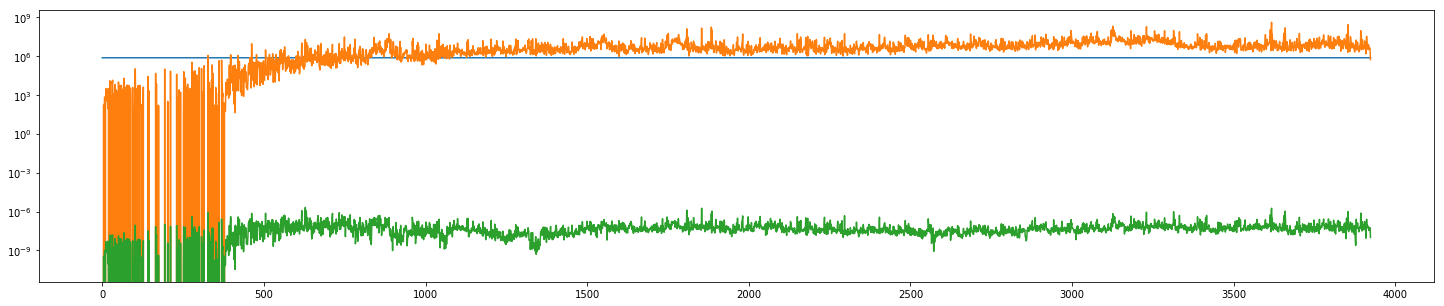

In [0]:
plt.figure(figsize=(25,5))
plt.plot(coins_destroyed_df)
plt.yscale('log')
plt.show()

## Calculate MVRV Z-Score

In [0]:
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [0]:
btc_metrics = pd.read_csv(io.BytesIO(uploaded['btc.csv']))

In [0]:
market_cap = btc_metrics['CapMrktCurUSD']
realized_cap = btc_metrics['CapRealUSD']
price_usd = btc_metrics['PriceUSD']

In [0]:
btc_metrics.tail()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
3923,2019-10-01,750562,143,156945742,1.097523e+06,1.466878,1.493970e+11,1.018469e+11,1.275982e+13,0.000141,1.174253,0.000082,0.682874,46.811357,389215.435912,1787.5,3.631020,1.486226e+07,1787.5,1.486226e+07,74.391606,61.087188,1,8314.551390,25.892501,-13.435396,1.796814e+07,331458,711678,241534.538579,2.008251e+09,0.771210,6412.265094,0.009960,82.812932,548853.182212,4.563468e+09,0.042507,0.029244,0.031675
3924,2019-10-02,717573,148,149838944,1.012425e+06,1.475603,1.502746e+11,1.018394e+11,1.275982e+13,0.000113,0.945295,0.000065,0.540805,37.244416,311457.570230,1850.0,3.757675,1.547068e+07,1850.0,1.547068e+07,89.932289,62.142278,1,8362.530732,28.481937,-19.415457,1.796999e+07,329482,699637,199816.911419,1.670975e+09,0.634376,5304.991639,0.010000,83.625307,443833.157198,3.711568e+09,0.042477,0.026533,0.031453
3925,2019-10-03,708956,147,152897685,1.040120e+06,1.457214,1.483456e+11,1.018008e+11,1.275982e+13,0.000116,0.961036,0.000061,0.499800,38.119195,314648.795856,1837.5,3.731760,1.516735e+07,1837.5,1.516735e+07,94.342067,61.650005,1,8254.339910,27.688066,-22.266600,1.797183e+07,327406,689533,190496.461054,1.572423e+09,0.778936,6429.601769,0.010000,82.543399,537102.011700,4.433423e+09,0.042493,0.025927,0.031357
3926,2019-10-04,712900,147,159837514,1.087330e+06,1.442091,1.467673e+11,1.017740e+11,1.275982e+13,0.000081,0.664573,0.000031,0.250687,27.422620,223924.507549,1837.5,3.731395,1.500445e+07,1837.5,1.500445e+07,93.048024,61.042462,1,8165.686151,24.756757,-22.799470,1.797367e+07,336945,721395,193165.491239,1.577329e+09,0.704438,5752.219131,0.009210,75.205969,508178.005467,4.149622e+09,0.042462,0.025917,0.029762
3927,2019-10-05,636638,158,140319573,8.880986e+05,1.437938,1.463511e+11,1.017785e+11,1.275982e+13,0.000058,0.475916,0.000014,0.118054,19.124261,155702.724201,1975.0,4.010255,1.607973e+07,1975.0,1.607973e+07,128.089284,61.014089,1,8141.633714,23.636276,-23.048284,1.797564e+07,327164,675545,140336.816020,1.142571e+09,0.524555,4270.735894,0.008584,69.887377,354360.605737,2.885074e+09,0.042448,0.025885,0.029575


In [0]:
z_score = (market_cap - realized_cap) / market_cap.std()

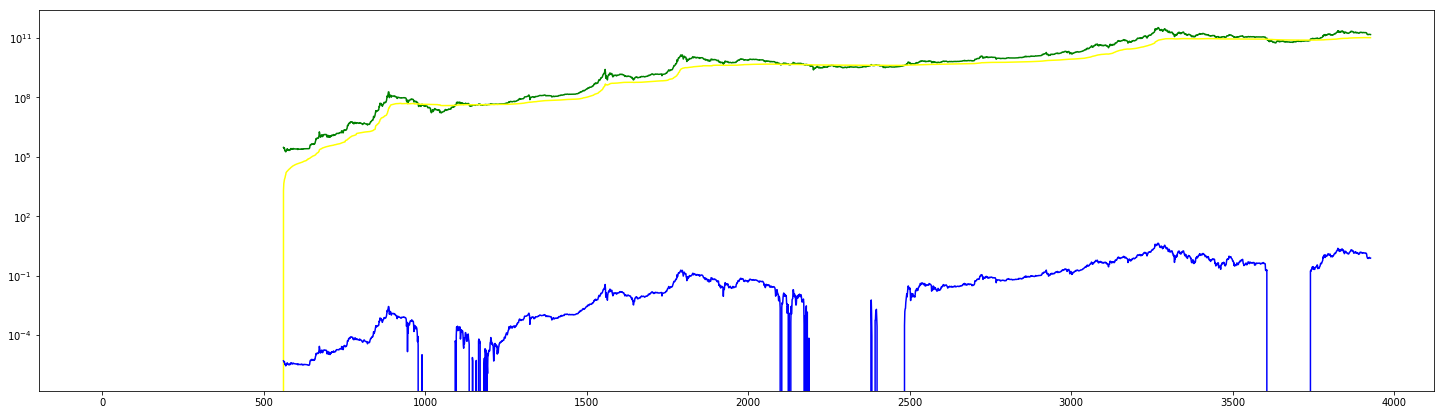

In [0]:
fig = plt.figure(figsize=(25,7))
# plt.plot(price_usd, label='Price', color='red')
plt.plot(market_cap, label='Market Cap', color='green')
plt.plot(realized_cap, label='Realized Cap', color='yellow')
plt.plot(z_score, label='Z-Score', color='blue')
plt.yscale('log')
plt.show()

## Normalize

In [0]:
# TODO: Read 'df' from file
dataset = df[['price(USD)', 'NVT', 'NVM']].copy()
dataset.head(5)

,price(USD),NVT,NVM,Dormancy
2013-07-29,98.60,16.751392,4.167444,NaN
2013-07-30,101.49,17.314178,4.144305,NaN
2013-07-31,107.95,18.445861,3.986644,NaN
2013-08-01,106.21,18.023297,3.452334,NaN
2013-08-02,104.86,17.654927,4.076786,NaN


In [0]:
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(5)

,price(USD),NVT,NVM
2013-07-29,-0.099734,0.048432,0.041045
2013-07-30,-0.099585,0.060144,0.035132
2013-07-31,-0.099251,0.083695,-0.005154
2013-08-01,-0.099341,0.074901,-0.141684
2013-08-02,-0.099411,0.067235,0.017879


## Display metrics

KeyError: ignored

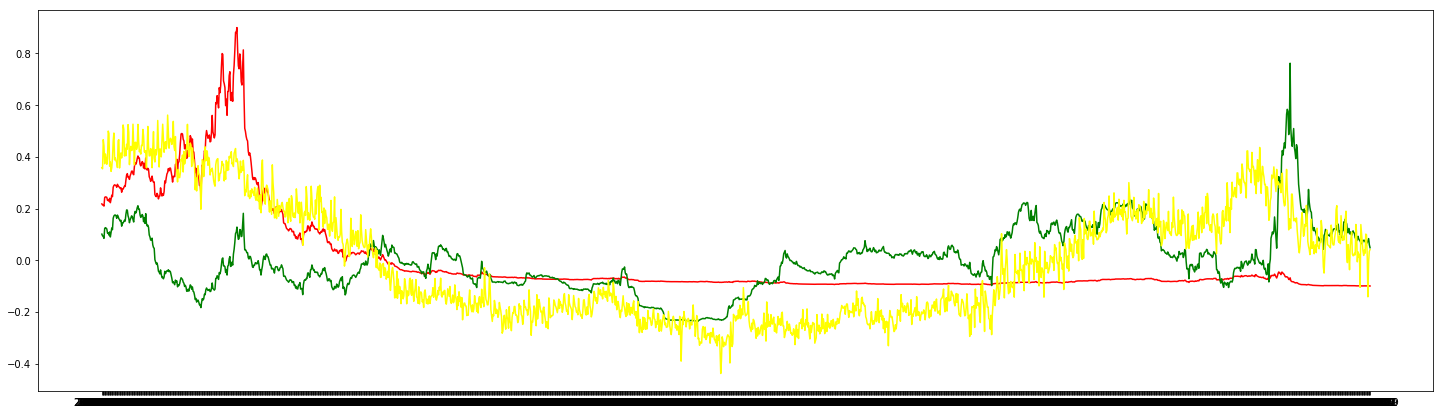

In [0]:
plt.figure(figsize=(25,7))
plt.plot(datasetNorm['price(USD)'][::-1], label='Price', color='red')
plt.plot(datasetNorm['NVT'][::-1], label='NVT', color='green')
plt.plot(datasetNorm['NVM'][::-1], label='NVM', color='yellow')
plt.plot(datasetNorm['dormancy'][::-1], label='NVM', color='blue')
plt.show()

In [0]:
from google.colab import files
uploaded = files.upload()

Saving average-coin-dormancy.json to average-coin-dormancy.json
Saving mvrv-ratio.json to mvrv-ratio.json
Saving nvt-signal.json to nvt-signal.json
Saving sopr.json to sopr.json
Saving velocity.json to velocity.json


In [0]:
dormancy_df = pd.read_json(io.BytesIO(uploaded['average-coin-dormancy.json']))
mvrv_df = pd.read_json(io.BytesIO(uploaded['mvrv-ratio.json']))
nvt_signal_df = pd.read_json(io.BytesIO(uploaded['nvt-signal.json']))
sopr_df = pd.read_json(io.BytesIO(uploaded['sopr.json']))
velocity_df = pd.read_json(io.BytesIO(uploaded['velocity.json']))

In [0]:
len(dormancy_df)

3946

In [0]:
mvrv_df.head()

,t,v
0,1279324800,0.012190
1,1279411200,0.015894
2,1279497600,0.022353
3,1279584000,0.019591
4,1279670400,0.017317


5

In [0]:
df = uploaded[0]
idx = 1
while idx < len(uploaded):
  df = pd.concat([df.set_index('t'), uploaded[idx].set_index('t')], axis=1, join='inner')
  idx += 1

KeyError: ignored

In [0]:
tmp.head()

,v,v
t,,
1279324800,17.557391,0.012190
1279411200,37.898148,0.015894
1279497600,8.009993,0.022353
1279584000,2.325436,0.019591
1279670400,23.594425,0.017317


In [0]:
def load_json(file, name):
  tmp = pd.read_json(io.BytesIO(uploaded[file]))
  pd.to_datetime(tmp['t'], unit='s')
  tmp = tmp.columns = ['time', name]
  return tmp

In [0]:
df = 
for file in uploaded:
  io.BytesIO(uploaded[file])
  load_json()


average-coin-dormancy.json
mvrv-ratio.json
nvt-signal.json
sopr.json
velocity.json


In [0]:
dormancy_df.head()

,t,v
0,1231718400,0.034873
1,1231804800,0.000000
2,1231891200,0.011776
3,1231977600,0.099891
4,1232064000,0.072979


In [0]:
pd.to_datetime(dormancy_df['t'], unit='s')

0      2009-01-12
1      2009-01-13
2      2009-01-14
3      2009-01-15
4      2009-01-16
          ...    
3941   2019-10-28
3942   2019-10-29
3943   2019-10-30
3944   2019-10-31
3945   2019-11-01
Name: t, Length: 3946, dtype: datetime64[ns]